In [1]:
import math
import time
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset,RandomSampler

In [2]:
epochs = 50
device = torch.device("cpu")

eps = 0.02

learning_rate = 1e-2
batchflag = True
batchsize = 128

start = 0.
end = 1.
x = np.linspace(start,end,100 )
y = np.linspace(start,end,100)
x, y = np.meshgrid(x, y)
x = np.reshape(x, (np.size(x[:]),1))
y = np.reshape(y, (np.size(y[:]),1))



def actual_soln(eps):
    p = 1 - np.exp(-1/eps);q = 1 + np.exp(-1/eps);d = 1/(q - 2*eps*p)
    return (np.sin(np.pi*x) + (eps*np.pi/p)*(np.exp(-x/eps) + np.exp((x-1)/eps) - q) ) * (2*y*(1 - y**2) + eps * ( p*d*(1-2*y) - 3*q/p + (3/p - d)*np.exp(-y/eps) + (3/p + d)*np.exp((y-1)/eps)))

In [3]:
def plot_graph(soln,soln_name):
    x = np.linspace(start,end,100);y = np.linspace(start,end,100)
    x,y = np.meshgrid(x,y)
    ax = plt.axes(projection='3d')
    ax.plot_surface(x,y,soln.reshape(100,100))
    plt.title(soln_name)
    plt.show()

class Swish(nn.Module):
	def __init__(self, inplace=True):
		super(Swish, self).__init__()
		self.inplace = inplace

	def forward(self, x):
		if self.inplace:
			x.mul_(torch.sigmoid(x))
			return x
		else:
			return x * torch.sigmoid(x)
	

class FBPINN(nn.Module):
	hid_dim = 128
	input_dim = 2 
	def __init__(self):
		super(FBPINN, self).__init__()
		self.tanh = nn.Tanh()
		self.lin0 = nn.Linear(self.input_dim,self.hid_dim)
		self.lin = nn.Linear(self.hid_dim,self.hid_dim)
		self.lin1 = nn.Linear(self.hid_dim,1)
		self.swish = Swish()
	def forward(self,x):		
		tanh1 = self.tanh(x)
		tanh2 = self.tanh(1 - x)
		tanh11 = (tanh1[:,0].unsqueeze(1))*(tanh1[:,1].unsqueeze(1))*(tanh1[:,0].unsqueeze(1))*(tanh1[:,1].unsqueeze(1))
		tanh22 = (tanh2[:,0].unsqueeze(1))*(tanh2[:,1].unsqueeze(1))*(tanh2[:,0].unsqueeze(1))*(tanh2[:,1].unsqueeze(1))
		x = self.lin0(x)
		x = self.swish(x)
		x = self.lin(x)
		x = self.swish(x)
		x = self.lin(x)
		x = self.swish(x)
		x = self.lin(x)
		x = self.swish(x)
		x = self.lin1(x)
		out = x*tanh11*tanh22
		return  out
	
def lag_coeffs(num):
		lis = [np.array([1]),np.array([1,-1])]
		for n in range(1,num-1):
			xl1 = np.concatenate((np.array([0]),lis[n]),axis = 0)
			l1 = np.concatenate((lis[n],np.array([0])),axis = 0)		
			l0 = np.concatenate((lis[n-1],np.array([0,0])),axis = 0)
			l = ((2*n + 1)*l1 - xl1 - n*l0)/(n + 1)
			lis.append(l)
		for n in range(num):
			lis[n] = np.concatenate((lis[n],np.array([0]*(num-1-n))),axis = 0)
		return lis

def poly(coeffs,x):
	sum = torch.zeros_like(x)
	for i,coeff in enumerate(coeffs):
		sum = sum + coeff*(x**i)
	return sum

class Lag_FBPINN(nn.Module):
	def __init__(self,basis_num):
		super(Lag_FBPINN,self).__init__()
		self.tanh = nn.Tanh()
		self.basis_num = basis_num
		self.main = nn.Sequential(
			#nn.Linear(2*basis_num,2*basis_num),
			nn.Linear(2*basis_num,1))		
	def forward(self,input):
		tanh1 = self.tanh(input)
		tanh2 = self.tanh(1 - input)
		tanh11 = (tanh1[:,0].unsqueeze(1))*(tanh1[:,1].unsqueeze(1))*(tanh1[:,0].unsqueeze(1))*(tanh1[:,1].unsqueeze(1))
		tanh22 = (tanh2[:,0].unsqueeze(1))*(tanh2[:,1].unsqueeze(1))*(tanh2[:,0].unsqueeze(1))*(tanh2[:,1].unsqueeze(1))
		coeffs = lag_coeffs(self.basis_num)
		x = input[:,0]
		t = input[:,1]
		netin = torch.Tensor([])
		for i in range(self.basis_num):
			netin = torch.cat((netin,poly(coeffs[i],x.view(-1,1))),1)
		for i in range(self.basis_num):
			netin = torch.cat((netin,poly(coeffs[i],t.view(-1,1))),1)
		netout = self.main(netin)
		return netout*tanh11*tanh22

In [4]:

def train(device,x,y,eps,learning_rate,epochs,batch_flag,batch_size):
	
	xnet = torch.Tensor(x)
	ynet = torch.Tensor(y) 
	
	if(batch_flag):
		dataset = TensorDataset(xnet,ynet)
		dataloader = DataLoader(dataset, batch_size=batch_size,shuffle=True,num_workers = 0,drop_last = True )
		print(len(dataloader))
		
	net = FBPINN()#FBPINN()#.to(device)
	
	def init_normal(m):
		if type(m) == nn.Linear:
			nn.init.kaiming_normal_(m.weight)

	net.apply(init_normal)

	optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)

	def Loss_criterion(xnet,ynet):
		xnet.requires_grad = True
		ynet.requires_grad = True
		points = torch.cat((xnet,ynet),1) 
		U = net(points)
		U = U.view(len(U),-1)
		
		p = 1 - np.exp(-1/eps);q = 1 + np.exp(-1/eps);d = 1/(q - 2*eps*p)
		
		soln = (torch.sin(np.pi*xnet) + (eps*np.pi/p)*(torch.exp(-xnet/eps) + torch.exp((xnet-1)/eps) - q) ) * (2*ynet*(1 - ynet*ynet) + eps * ( p*d*(1-2*ynet) - 3*q/p + (3/p - d)*torch.exp(-ynet/eps) + (3/p + d)*torch.exp((ynet-1)/eps)))
		
		soln_x = torch.autograd.grad(soln,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_xx = torch.autograd.grad(soln_x,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_xxx = torch.autograd.grad(soln_xx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_xxxx = torch.autograd.grad(soln_xxx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_y = torch.autograd.grad(soln,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_yy = torch.autograd.grad(soln_y,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_yyy = torch.autograd.grad(soln_yy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_yyyy = torch.autograd.grad(soln_yyy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_xxy = torch.autograd.grad(soln_xx,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_xxyy = torch.autograd.grad(soln_xxy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]

		f = (eps**2)*(soln_xxxx + soln_yyyy + 2*soln_xxyy) - (soln_xx + soln_yy)
		
		U_x = torch.autograd.grad(U,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_xx = torch.autograd.grad(U_x,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_xxx = torch.autograd.grad(U_xx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_xxxx = torch.autograd.grad(U_xxx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_y = torch.autograd.grad(U,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_yy = torch.autograd.grad(U_y,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_yyy = torch.autograd.grad(U_yy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_yyyy = torch.autograd.grad(U_yyy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_xxy = torch.autograd.grad(U_xx,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_xxyy = torch.autograd.grad(U_xxy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		loss1 = (eps**2)*(U_xxxx + U_yyyy + 2*U_xxyy) - (U_xx + U_yy) - f 
		
		return nn.MSELoss()(loss1,torch.zeros_like(loss1)) 

	losses = [];errors = []
	tic = time.time()

	if(batch_flag):
		for epoch in range(epochs):
			if epoch == 50:
				learning_rate = 0.00001
				new_optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)
				optimizer = new_optimizer
			for batch_idx, (x_in,y_in) in enumerate(dataloader):

				net.zero_grad()
				loss = Loss_criterion(x_in,y_in)
				loss.backward()

				optimizer.step() 
				if batch_idx % 20 ==0:
					print('Train Epoch: {} \tLoss: {:.20f}'.format(epoch, loss.item()))

			points = torch.cat((xnet,ynet),1)
			U = net(points)
			z = U.detach().numpy()
			actual_loss = np.square(actual_soln(eps) - z).mean()
			print('\nAfter Epoch {}, \t Actual solution loss: {:.20f}\n'.format(
				epoch, actual_loss))
			if epoch % 1 == 0:
				plot_graph(z,'Predicted solution')
			losses.append(loss.item())
			errors.append(actual_loss)
	else:
		for epoch in range(epochs):
			if epoch == 50:
				learning_rate = 0.00001
				new_optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)
				optimizer = new_optimizer
		
			net.zero_grad()
			loss = Loss_criterion(xnet,ynet)
			loss.backward()
			
			optimizer.step() 
			points = torch.cat((xnet,ynet),1)
			U = net(points)
			z = U.detach().numpy()
			actual_loss = np.square(actual_soln(eps) - z).mean()
			print('\nAfter Epoch {}, \t Actual solution loss: {:.20f}\n'.format(
				epoch, actual_loss))
			if epoch % 5 == 0:
				plot_graph(z,'Predicted solution')
			losses.append(loss.item())
			errors.append(actual_loss)
	toc = time.time()
	elapseTime = toc - tic
	print ("Time elapsed = ", elapseTime)

	net_in = torch.cat((xnet,ynet),1)
	output = net(net_in)  
	
	return output,losses,errors 

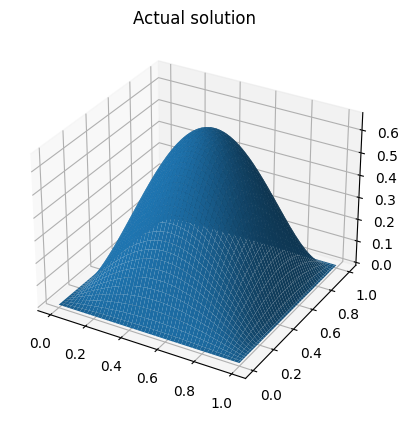

In [5]:
plot_graph(actual_soln(eps),'Actual solution')

78
Train Epoch: 0 	Loss: 60.84860610961914062500
Train Epoch: 0 	Loss: 48.99568176269531250000
Train Epoch: 0 	Loss: 54.33156585693359375000
Train Epoch: 0 	Loss: 42.59036254882812500000

After Epoch 0, 	 Actual solution loss: 0.07556563612664814189



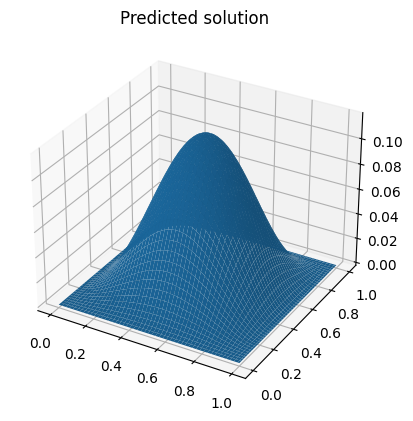

Train Epoch: 1 	Loss: 46.88488769531250000000
Train Epoch: 1 	Loss: 43.67806243896484375000
Train Epoch: 1 	Loss: 49.79019165039062500000
Train Epoch: 1 	Loss: 63.64820861816406250000

After Epoch 1, 	 Actual solution loss: 0.06402192608122325712



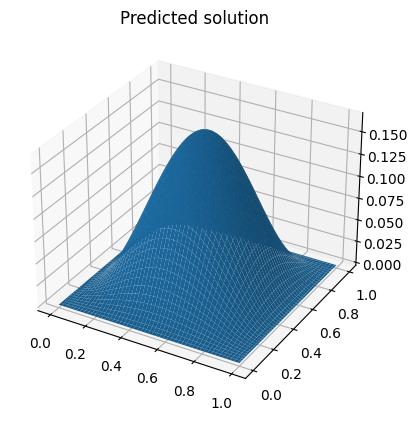

Train Epoch: 2 	Loss: 45.40336608886718750000
Train Epoch: 2 	Loss: 59.64349365234375000000
Train Epoch: 2 	Loss: 52.47896575927734375000
Train Epoch: 2 	Loss: 55.72717285156250000000

After Epoch 2, 	 Actual solution loss: 0.08095864291203232199



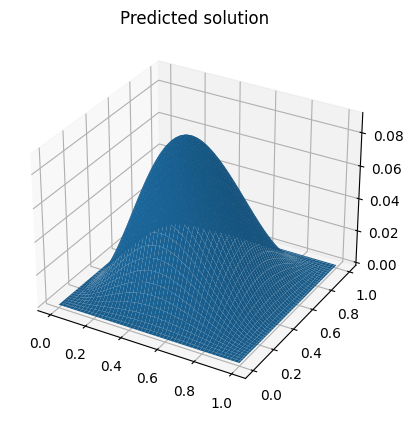

Train Epoch: 3 	Loss: 50.27393341064453125000
Train Epoch: 3 	Loss: 47.73115158081054687500
Train Epoch: 3 	Loss: 49.77201080322265625000
Train Epoch: 3 	Loss: 51.82019042968750000000

After Epoch 3, 	 Actual solution loss: 0.06429454513664874249



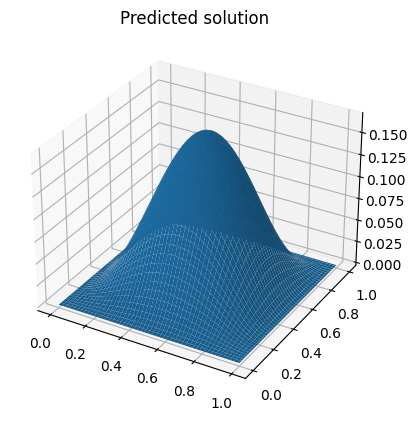

Train Epoch: 4 	Loss: 56.57678985595703125000
Train Epoch: 4 	Loss: 49.35105895996093750000
Train Epoch: 4 	Loss: 57.19098281860351562500
Train Epoch: 4 	Loss: 49.52130508422851562500

After Epoch 4, 	 Actual solution loss: 0.06383461923937137905



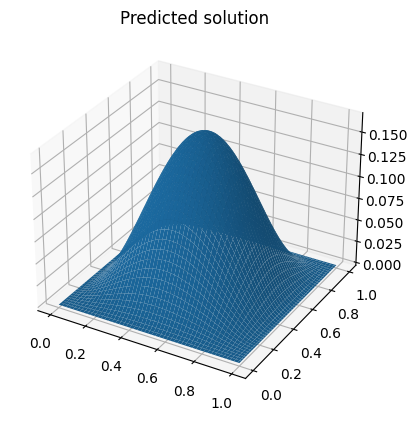

Train Epoch: 5 	Loss: 51.39366149902343750000
Train Epoch: 5 	Loss: 53.26935577392578125000
Train Epoch: 5 	Loss: 48.85701751708984375000
Train Epoch: 5 	Loss: 51.70648956298828125000

After Epoch 5, 	 Actual solution loss: 0.06899151300902717221



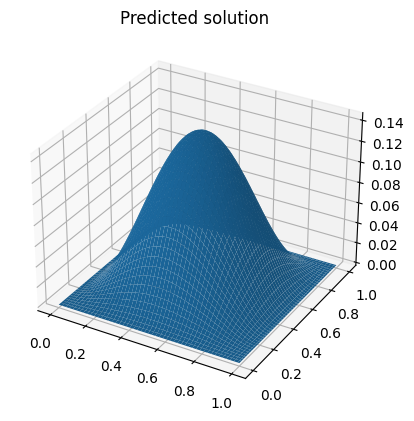

Train Epoch: 6 	Loss: 48.44560241699218750000
Train Epoch: 6 	Loss: 50.74369430541992187500
Train Epoch: 6 	Loss: 55.52225112915039062500
Train Epoch: 6 	Loss: 43.19222259521484375000

After Epoch 6, 	 Actual solution loss: 0.06373649665420359767



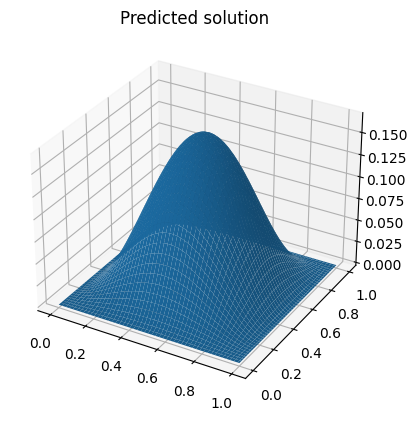

Train Epoch: 7 	Loss: 44.70877075195312500000
Train Epoch: 7 	Loss: 50.69935607910156250000
Train Epoch: 7 	Loss: 43.53897857666015625000
Train Epoch: 7 	Loss: 53.29336166381835937500

After Epoch 7, 	 Actual solution loss: 0.05854720390293175619



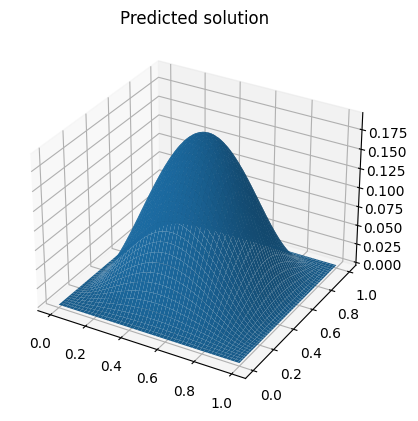

Train Epoch: 8 	Loss: 48.81032562255859375000
Train Epoch: 8 	Loss: 50.55850601196289062500
Train Epoch: 8 	Loss: 48.69479370117187500000
Train Epoch: 8 	Loss: 46.10165405273437500000

After Epoch 8, 	 Actual solution loss: 0.06688458719537128394



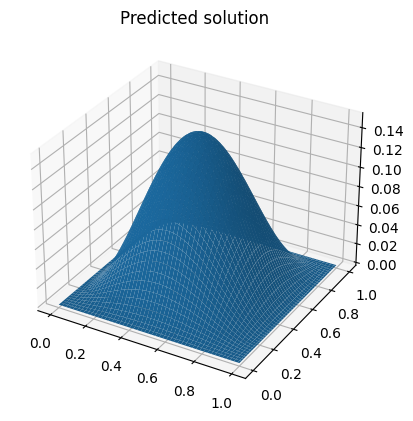

Train Epoch: 9 	Loss: 49.74163436889648437500
Train Epoch: 9 	Loss: 45.98274612426757812500
Train Epoch: 9 	Loss: 44.74272918701171875000
Train Epoch: 9 	Loss: 48.62005233764648437500

After Epoch 9, 	 Actual solution loss: 0.07240531746918449363



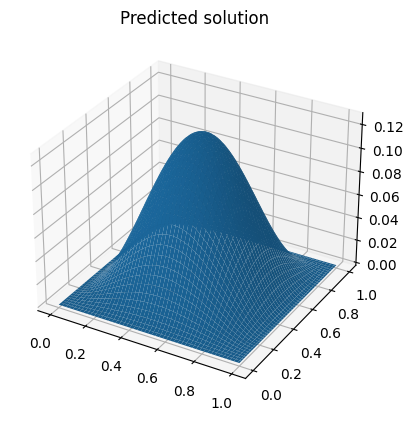

Train Epoch: 10 	Loss: 56.30954742431640625000
Train Epoch: 10 	Loss: 47.38964843750000000000
Train Epoch: 10 	Loss: 49.77335739135742187500
Train Epoch: 10 	Loss: 49.72270202636718750000

After Epoch 10, 	 Actual solution loss: 0.05868379924253939312



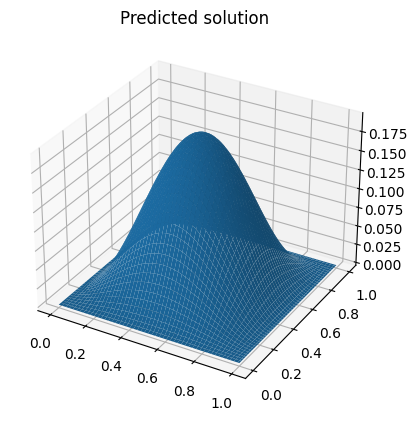

Train Epoch: 11 	Loss: 53.47084808349609375000
Train Epoch: 11 	Loss: 50.17767333984375000000
Train Epoch: 11 	Loss: 46.29252624511718750000
Train Epoch: 11 	Loss: 36.94631195068359375000

After Epoch 11, 	 Actual solution loss: 0.05129215386598563048



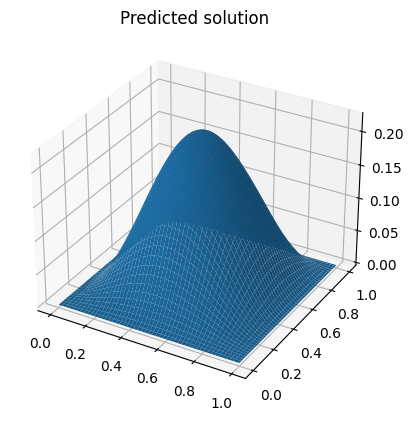

Train Epoch: 12 	Loss: 70.01055145263671875000
Train Epoch: 12 	Loss: 54.33677673339843750000
Train Epoch: 12 	Loss: 56.98698425292968750000
Train Epoch: 12 	Loss: 53.43644714355468750000

After Epoch 12, 	 Actual solution loss: 0.06425006900370328067



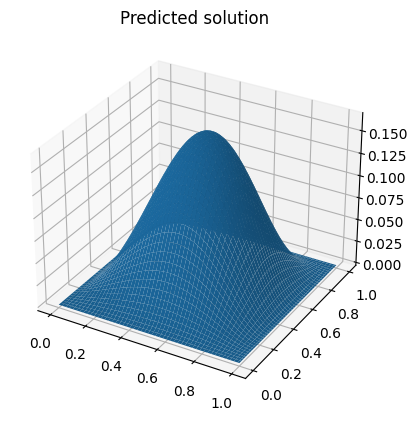

Train Epoch: 13 	Loss: 50.01263427734375000000
Train Epoch: 13 	Loss: 42.01195144653320312500
Train Epoch: 13 	Loss: 57.78803634643554687500
Train Epoch: 13 	Loss: 47.42329788208007812500

After Epoch 13, 	 Actual solution loss: 0.07187964471498259345



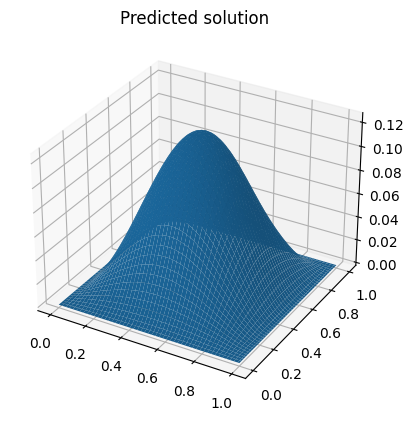

Train Epoch: 14 	Loss: 54.74467849731445312500
Train Epoch: 14 	Loss: 41.75613403320312500000
Train Epoch: 14 	Loss: 54.33597564697265625000
Train Epoch: 14 	Loss: 50.57695770263671875000

After Epoch 14, 	 Actual solution loss: 0.05314819833871207294



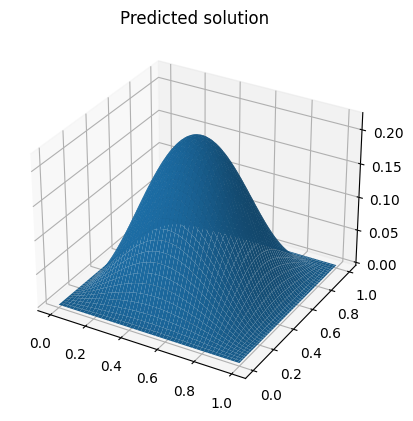

Train Epoch: 15 	Loss: 45.75575256347656250000
Train Epoch: 15 	Loss: 62.58941650390625000000
Train Epoch: 15 	Loss: 55.26168823242187500000
Train Epoch: 15 	Loss: 50.16810607910156250000

After Epoch 15, 	 Actual solution loss: 0.02827479036784548080



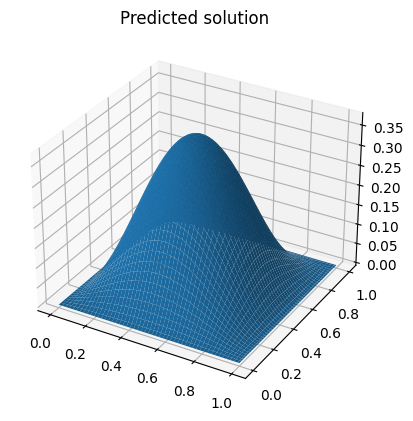

Train Epoch: 16 	Loss: 51.87641525268554687500
Train Epoch: 16 	Loss: 43.15890121459960937500
Train Epoch: 16 	Loss: 44.28072738647460937500
Train Epoch: 16 	Loss: 51.43200683593750000000

After Epoch 16, 	 Actual solution loss: 0.06297736193419108119



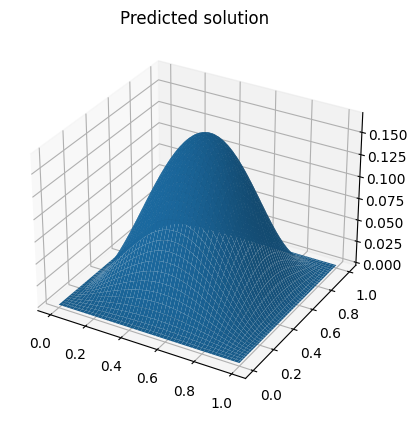

Train Epoch: 17 	Loss: 53.27665710449218750000
Train Epoch: 17 	Loss: 51.83426666259765625000
Train Epoch: 17 	Loss: 50.16913223266601562500
Train Epoch: 17 	Loss: 51.27315902709960937500

After Epoch 17, 	 Actual solution loss: 0.06458086858777078998



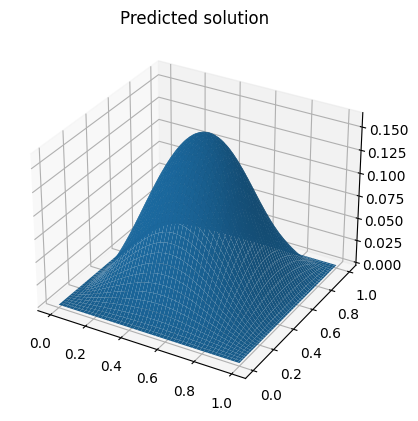

Train Epoch: 18 	Loss: 42.81619262695312500000
Train Epoch: 18 	Loss: 44.63127899169921875000
Train Epoch: 18 	Loss: 54.43667221069335937500
Train Epoch: 18 	Loss: 41.42440795898437500000

After Epoch 18, 	 Actual solution loss: 0.05629182492777187047



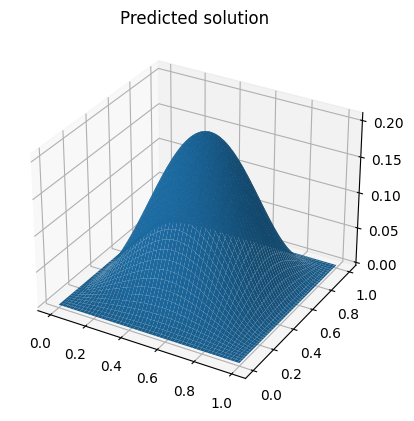

Train Epoch: 19 	Loss: 46.30140304565429687500
Train Epoch: 19 	Loss: 48.28693008422851562500
Train Epoch: 19 	Loss: 48.37688827514648437500
Train Epoch: 19 	Loss: 40.78470993041992187500

After Epoch 19, 	 Actual solution loss: 0.06035088898790245265



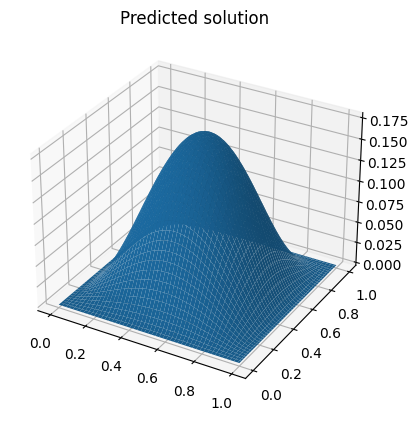

Train Epoch: 20 	Loss: 38.58224868774414062500
Train Epoch: 20 	Loss: 47.56891250610351562500
Train Epoch: 20 	Loss: 53.64302062988281250000
Train Epoch: 20 	Loss: 38.96990585327148437500

After Epoch 20, 	 Actual solution loss: 0.05598201802869052363



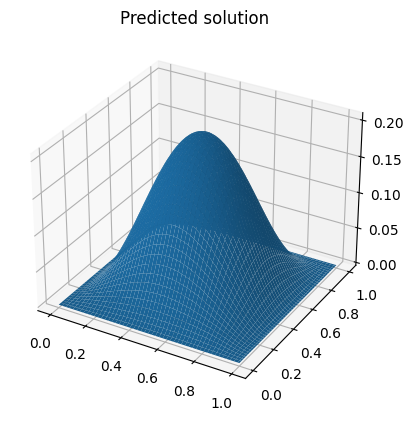

Train Epoch: 21 	Loss: 46.27057266235351562500
Train Epoch: 21 	Loss: 56.41576004028320312500
Train Epoch: 21 	Loss: 50.01932144165039062500
Train Epoch: 21 	Loss: 49.24778747558593750000

After Epoch 21, 	 Actual solution loss: 0.05026825231718374393



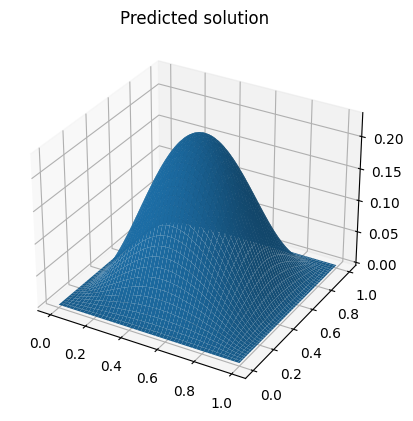

Train Epoch: 22 	Loss: 46.54655456542968750000
Train Epoch: 22 	Loss: 38.89492034912109375000
Train Epoch: 22 	Loss: 48.03944015502929687500
Train Epoch: 22 	Loss: 52.35081481933593750000

After Epoch 22, 	 Actual solution loss: 0.05905873887443612025



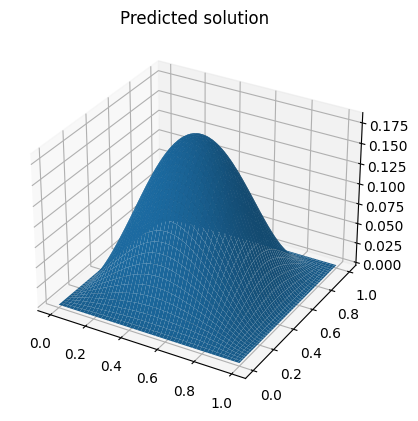

Train Epoch: 23 	Loss: 49.56764984130859375000
Train Epoch: 23 	Loss: 42.97571182250976562500
Train Epoch: 23 	Loss: 48.69448852539062500000
Train Epoch: 23 	Loss: 46.32490158081054687500

After Epoch 23, 	 Actual solution loss: 0.04813127305275833462



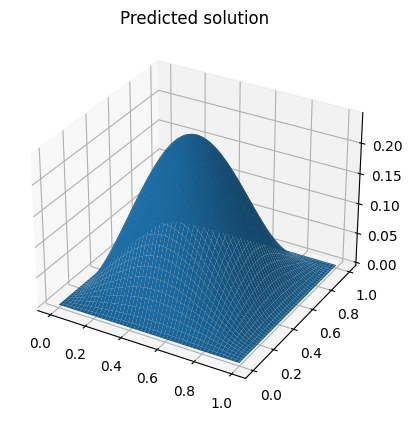

Train Epoch: 24 	Loss: 44.22573852539062500000
Train Epoch: 24 	Loss: 56.60332489013671875000
Train Epoch: 24 	Loss: 43.31445312500000000000
Train Epoch: 24 	Loss: 38.47969055175781250000

After Epoch 24, 	 Actual solution loss: 0.03670709046595031777



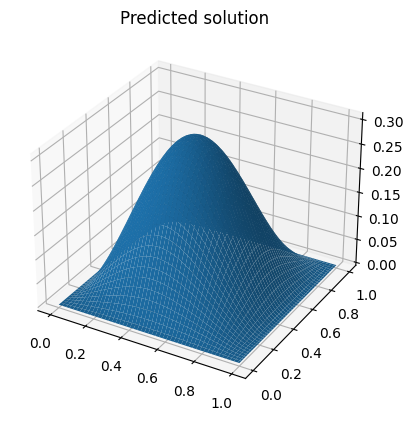

Train Epoch: 25 	Loss: 39.10127639770507812500
Train Epoch: 25 	Loss: 45.96707534790039062500
Train Epoch: 25 	Loss: 38.27348327636718750000
Train Epoch: 25 	Loss: 33.33508300781250000000

After Epoch 25, 	 Actual solution loss: 0.02387338007334611351



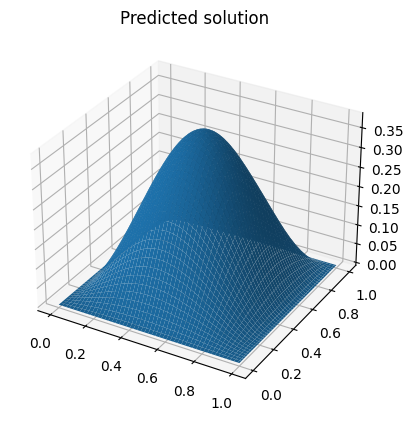

Train Epoch: 26 	Loss: 28.52774238586425781250
Train Epoch: 26 	Loss: 44.00887298583984375000
Train Epoch: 26 	Loss: 42.34582138061523437500
Train Epoch: 26 	Loss: 44.95567703247070312500

After Epoch 26, 	 Actual solution loss: 0.03980537144747939987



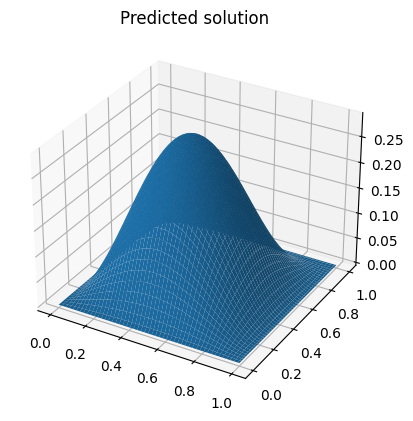

Train Epoch: 27 	Loss: 37.90255355834960937500
Train Epoch: 27 	Loss: 40.12581634521484375000
Train Epoch: 27 	Loss: 49.85986328125000000000
Train Epoch: 27 	Loss: 49.80644989013671875000

After Epoch 27, 	 Actual solution loss: 0.05626548365567055066



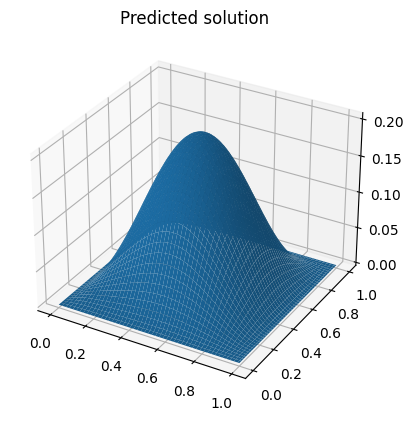

Train Epoch: 28 	Loss: 45.42687225341796875000
Train Epoch: 28 	Loss: 55.97533416748046875000
Train Epoch: 28 	Loss: 47.51893234252929687500
Train Epoch: 28 	Loss: 48.59696197509765625000

After Epoch 28, 	 Actual solution loss: 0.05007849721585345970



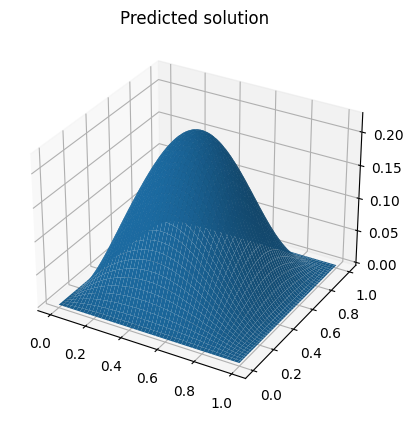

Train Epoch: 29 	Loss: 40.57246017456054687500
Train Epoch: 29 	Loss: 48.01517486572265625000
Train Epoch: 29 	Loss: 46.43955612182617187500
Train Epoch: 29 	Loss: 40.27666473388671875000

After Epoch 29, 	 Actual solution loss: 0.04157377915853683464



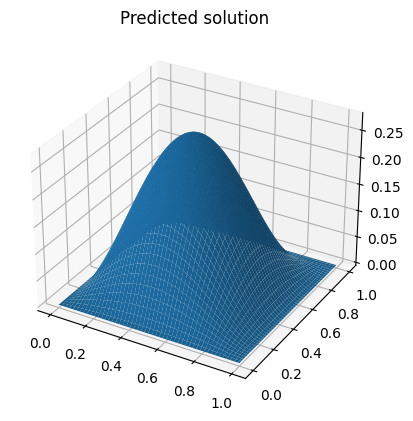

Train Epoch: 30 	Loss: 34.84328460693359375000
Train Epoch: 30 	Loss: 43.03254318237304687500
Train Epoch: 30 	Loss: 44.00066375732421875000
Train Epoch: 30 	Loss: 53.80931854248046875000

After Epoch 30, 	 Actual solution loss: 0.05620606186659946046



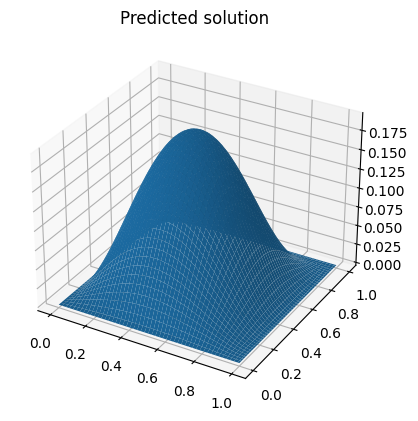

Train Epoch: 31 	Loss: 44.15882492065429687500
Train Epoch: 31 	Loss: 34.77454376220703125000
Train Epoch: 31 	Loss: 36.39485931396484375000
Train Epoch: 31 	Loss: 37.82501983642578125000

After Epoch 31, 	 Actual solution loss: 0.03882227895371189591



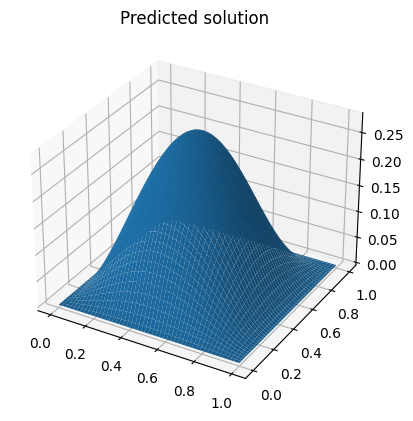

Train Epoch: 32 	Loss: 33.82320785522460937500
Train Epoch: 32 	Loss: 32.34683609008789062500
Train Epoch: 32 	Loss: 47.83887481689453125000
Train Epoch: 32 	Loss: 43.12548065185546875000

After Epoch 32, 	 Actual solution loss: 0.04029952585196033138



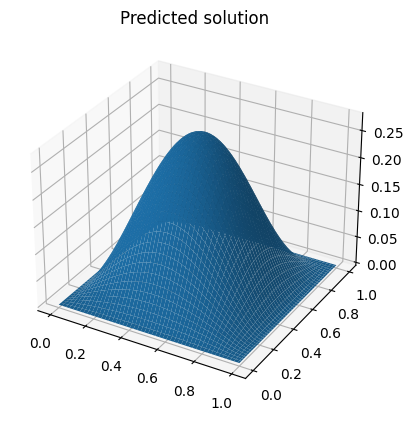

Train Epoch: 33 	Loss: 54.10126495361328125000
Train Epoch: 33 	Loss: 54.44329452514648437500
Train Epoch: 33 	Loss: 52.48269653320312500000
Train Epoch: 33 	Loss: 42.55645751953125000000

After Epoch 33, 	 Actual solution loss: 0.05231919973901078685



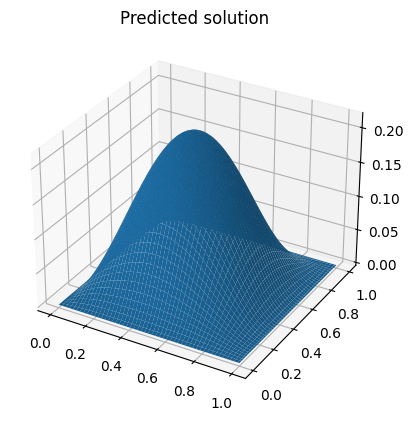

Train Epoch: 34 	Loss: 36.21688461303710937500
Train Epoch: 34 	Loss: 39.12183380126953125000
Train Epoch: 34 	Loss: 49.97805786132812500000
Train Epoch: 34 	Loss: 40.64565658569335937500

After Epoch 34, 	 Actual solution loss: 0.04614041985180510064



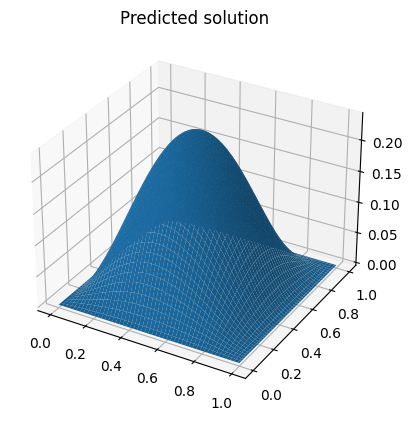

Train Epoch: 35 	Loss: 43.92829132080078125000
Train Epoch: 35 	Loss: 42.03398132324218750000
Train Epoch: 35 	Loss: 33.22948837280273437500
Train Epoch: 35 	Loss: 40.15847778320312500000

After Epoch 35, 	 Actual solution loss: 0.02103630582720648901



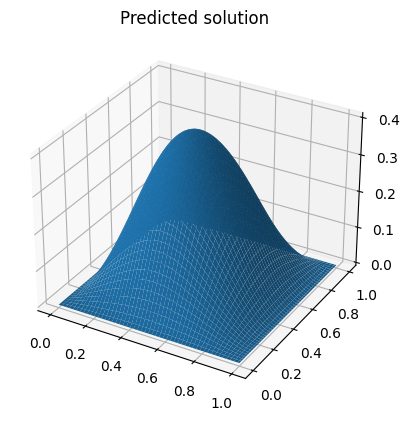

Train Epoch: 36 	Loss: 25.21066856384277343750
Train Epoch: 36 	Loss: 42.38539123535156250000
Train Epoch: 36 	Loss: 19.46286582946777343750
Train Epoch: 36 	Loss: 38.68924713134765625000

After Epoch 36, 	 Actual solution loss: 0.04910753800671772973



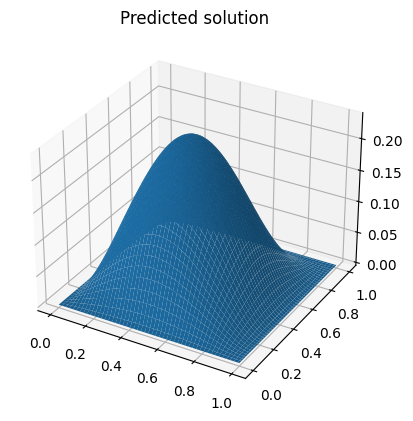

Train Epoch: 37 	Loss: 48.58563232421875000000
Train Epoch: 37 	Loss: 52.97526550292968750000
Train Epoch: 37 	Loss: 42.97721862792968750000
Train Epoch: 37 	Loss: 40.91830444335937500000

After Epoch 37, 	 Actual solution loss: 0.03271061851452049252



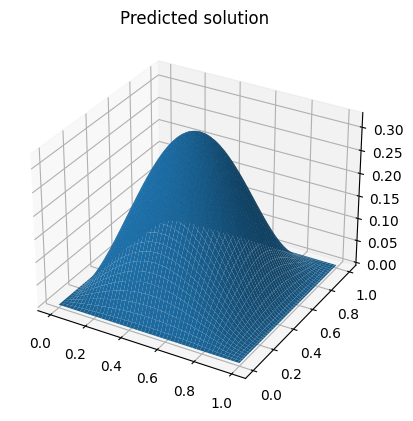

Train Epoch: 38 	Loss: 35.24196243286132812500
Train Epoch: 38 	Loss: 56.72756958007812500000
Train Epoch: 38 	Loss: 26.01996421813964843750
Train Epoch: 38 	Loss: 36.05189895629882812500

After Epoch 38, 	 Actual solution loss: 0.03369733851230417854



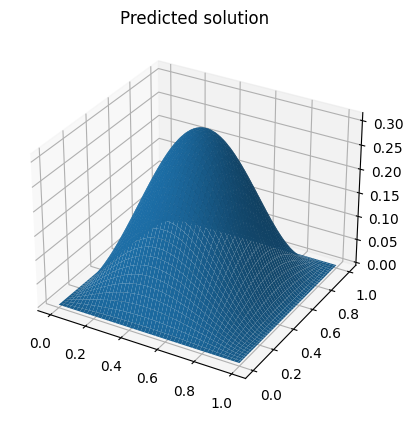

Train Epoch: 39 	Loss: 30.51587104797363281250
Train Epoch: 39 	Loss: 16.26652526855468750000
Train Epoch: 39 	Loss: 31.82228469848632812500
Train Epoch: 39 	Loss: 42.13174819946289062500

After Epoch 39, 	 Actual solution loss: 0.02970134586172458110



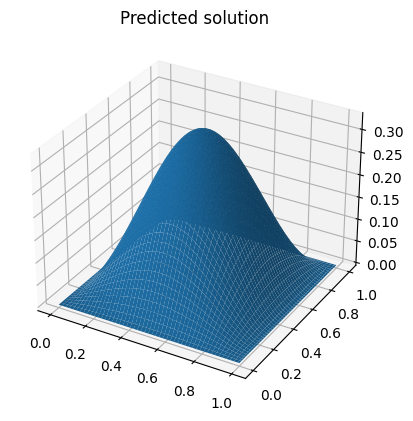

Train Epoch: 40 	Loss: 25.68564414978027343750
Train Epoch: 40 	Loss: 23.90549468994140625000
Train Epoch: 40 	Loss: 35.01728820800781250000
Train Epoch: 40 	Loss: 21.62863159179687500000

After Epoch 40, 	 Actual solution loss: 0.00799893328075412108



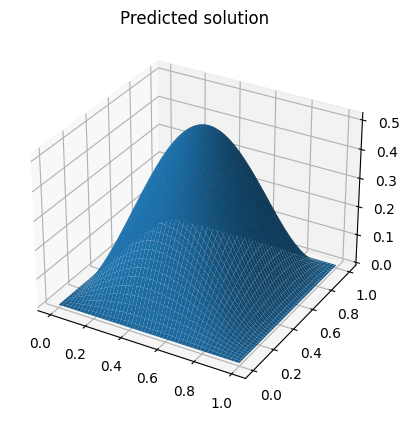

Train Epoch: 41 	Loss: 15.14911270141601562500
Train Epoch: 41 	Loss: 18.18937110900878906250
Train Epoch: 41 	Loss: 13.92554092407226562500
Train Epoch: 41 	Loss: 15.08381462097167968750

After Epoch 41, 	 Actual solution loss: 0.01665222296068988653



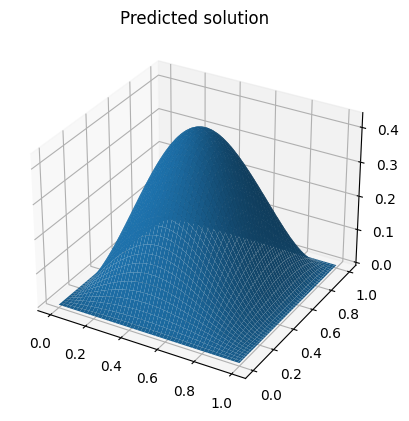

Train Epoch: 42 	Loss: 20.25743865966796875000
Train Epoch: 42 	Loss: 16.93362236022949218750
Train Epoch: 42 	Loss: 14.61486148834228515625
Train Epoch: 42 	Loss: 19.33417510986328125000

After Epoch 42, 	 Actual solution loss: 0.01288935587340294883



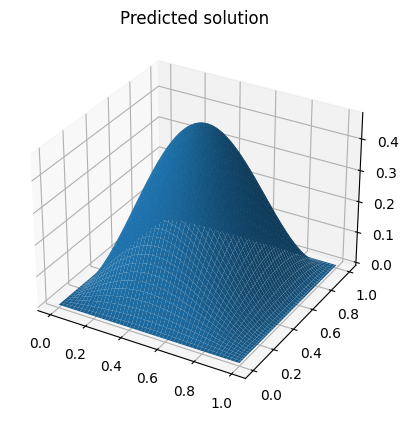

Train Epoch: 43 	Loss: 13.11849784851074218750
Train Epoch: 43 	Loss: 15.88206577301025390625
Train Epoch: 43 	Loss: 18.41901588439941406250
Train Epoch: 43 	Loss: 16.13717460632324218750

After Epoch 43, 	 Actual solution loss: 0.01341128642950636246



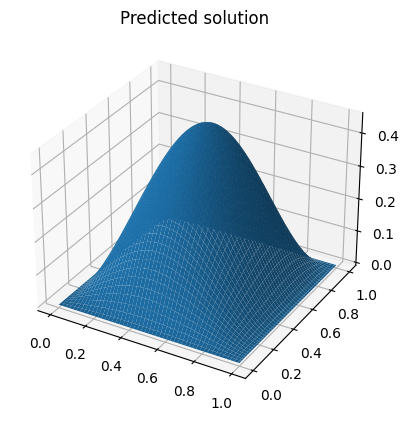

Train Epoch: 44 	Loss: 21.58026695251464843750
Train Epoch: 44 	Loss: 18.85655403137207031250
Train Epoch: 44 	Loss: 17.96993637084960937500
Train Epoch: 44 	Loss: 13.96260929107666015625

After Epoch 44, 	 Actual solution loss: 0.00898306698058437200



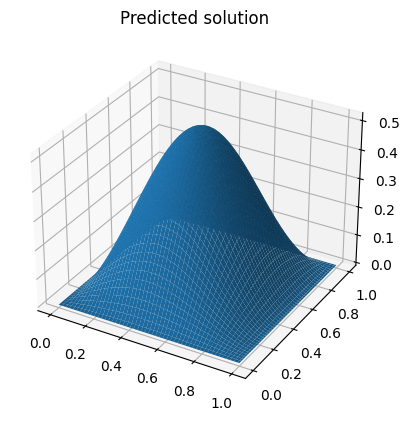

Train Epoch: 45 	Loss: 23.17444610595703125000
Train Epoch: 45 	Loss: 12.09857940673828125000
Train Epoch: 45 	Loss: 14.30669307708740234375
Train Epoch: 45 	Loss: 18.47798919677734375000

After Epoch 45, 	 Actual solution loss: 0.01045101098272347220



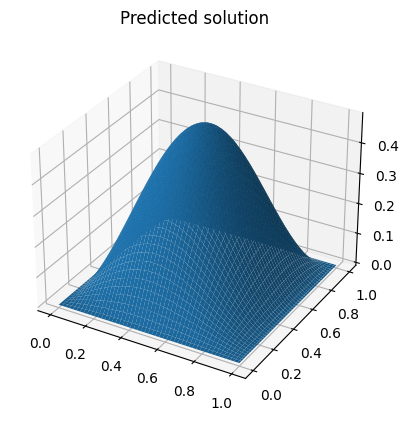

Train Epoch: 46 	Loss: 12.92491436004638671875
Train Epoch: 46 	Loss: 12.56737709045410156250
Train Epoch: 46 	Loss: 12.45594501495361328125
Train Epoch: 46 	Loss: 21.45307731628417968750

After Epoch 46, 	 Actual solution loss: 0.01666943859520663221



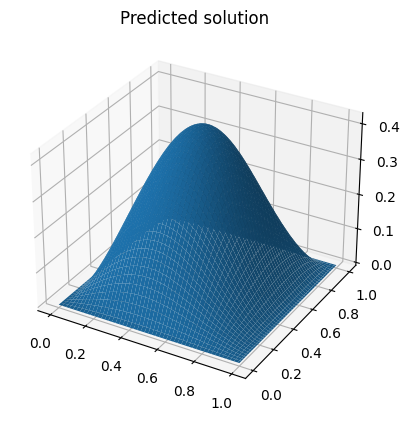

Train Epoch: 47 	Loss: 22.16326522827148437500
Train Epoch: 47 	Loss: 20.43855476379394531250
Train Epoch: 47 	Loss: 15.20737743377685546875
Train Epoch: 47 	Loss: 17.26335334777832031250

After Epoch 47, 	 Actual solution loss: 0.00572243389990001808



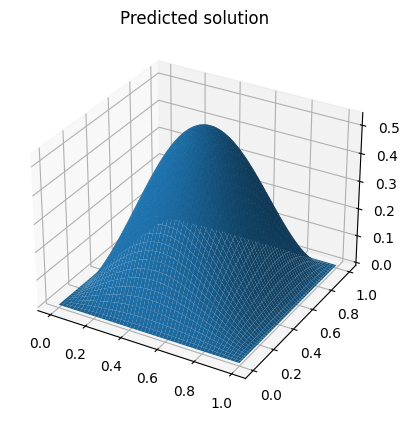

Train Epoch: 48 	Loss: 8.67601871490478515625
Train Epoch: 48 	Loss: 14.54547977447509765625
Train Epoch: 48 	Loss: 13.67010879516601562500
Train Epoch: 48 	Loss: 11.50079250335693359375

After Epoch 48, 	 Actual solution loss: 0.00968963377460524411



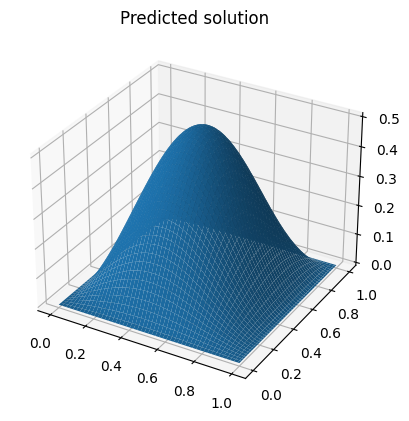

Train Epoch: 49 	Loss: 14.98377323150634765625
Train Epoch: 49 	Loss: 14.59957122802734375000
Train Epoch: 49 	Loss: 14.90691757202148437500
Train Epoch: 49 	Loss: 15.79764175415039062500

After Epoch 49, 	 Actual solution loss: 0.01388218842415417896



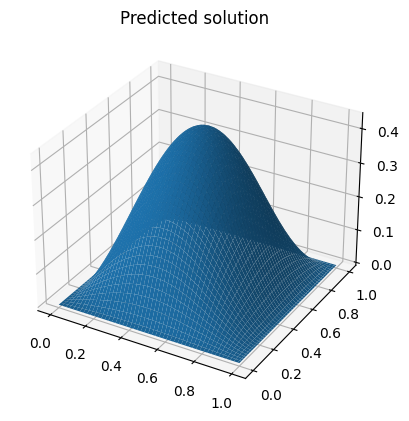

Time elapsed =  1933.279586315155


ValueError: too many values to unpack (expected 2)

In [6]:
output,losses,errors = train(device,x,y,eps,learning_rate,epochs,batchflag,batchsize)

In [ ]:
z = output.detach().numpy()
plot_graph(z,"Predicted Solution")
plot_graph(actual_soln(eps),"Actual Solution")

In [ ]:
plt.plot(losses)
plt.show()